In [1]:
%matplotlib inline
# Single Shot Multi-box Detection(SSD) #
import torch
import torchvision
from torch import nn
from torch.nn import functional as F

import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import time
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Bounding Boxes #

def box_corner_to_center(boxes): # boxes have the shape = (n, 5) , n is the number of bounding boxes
  """Convert from (upper-left, lower-right) to (center, width, height)."""
  x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  cx = (x1 + x2) / 2
  cy = (y1 + y2) / 2
  w = x2 - x1
  h = y2 - y1
  boxes = torch.stack((cx, cy, w, h), axis=-1)
  return boxes

In [4]:

def box_center_to_corner(boxes):
  """Convert from (center, width, height) to (upper-left, lower-right)."""
  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1, y1, x2, y2), axis=-1)
  return boxes

In [5]:
# Predicting Bounding Boxes with Non-Maximum Suppression #

def offset_inverse(anchors, offset_preds):
  """Predict bounding boxes based on anchor boxes with predicted offsets."""
  anc = box_corner_to_center(anchors[:,:4])
  pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
  pred_bbox_wh = torch.exp(offset_preds[:, 2:4] / 5) * anc[:, 2:]
  pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
  predicted_bbox = box_center_to_corner(pred_bbox)

  pred_bbox_angle = anc[:, -1] + offset_preds[:, -1] 
  
  # Concatenate predicted bounding box with predicted angle
  predicted_bbox_with_angle = torch.cat([predicted_bbox, pred_bbox_angle.unsqueeze(dim=1)], axis=1)
  return predicted_bbox_with_angle

In [6]:
from shapely.geometry import Polygon
from math import cos, sin, radians
import numpy as np
def rotate_box(box):
    """Calculate the four corners of a rotated box."""
    # cx, cy, w, h, angle = box
    cx, cy, w, h, angle = box
    # angle = 0


    angle = radians(angle*360) # because angles are normalized between 0 and 1(devided by 360)
    dx = w / 2
    dy = h / 2
    # Calculate the four corners of the rotated rectangle
    corners = np.array([
        [cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)],
        [cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)],
        [cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle)]
    ])
    return corners

def polygon_area(corners):
    """Calculate the area of a polygon given its corners."""
    poly = Polygon(corners)
    return poly.area

def polygon_intersection(corners1, corners2):
    """Calculate the intersection area between two polygons."""
    poly1 = Polygon(corners1)
    poly2 = Polygon(corners2)
    inter_area = poly1.intersection(poly2).area
    return inter_area

def box_iou_oriented(boxes1, boxes2):
    """Compute pairwise IoU for rotated bounding boxes (TensorFlow)."""
    batch_size_1 = boxes1.shape[0]
    batch_size_2 = boxes2.shape[0]
    
    iou_matrix = np.zeros((batch_size_1, batch_size_2))
    
    for i in range(batch_size_1):
        corners1 = rotate_box(boxes1[i].cpu().numpy())
        area1 = polygon_area(corners1)
        
        for j in range(batch_size_2):
            corners2 = rotate_box(boxes2[j].cpu().numpy())
            area2 = polygon_area(corners2)
            inter_area = polygon_intersection(corners1, corners2)
            union_area = area1 + area2 - inter_area
            iou_matrix[i, j] = inter_area / union_area if union_area != 0 else 0.0
    
    return torch.tensor(iou_matrix, dtype=torch.float64, device=device)


In [7]:

def multibox_prior(data, sizes, ratios, rotations=[0.0, 45.0, 90.0, 135.0, 180.0]):
  """Generate anchor boxes with different shapes centered on each pixel."""
  rotations = [angle/360  for angle in rotations] 

  in_height, in_width = data.shape[-2:]
  device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
  boxes_per_pixel = (num_sizes + num_ratios - 1)
  size_tensor = torch.tensor(sizes, device=device)
  ratio_tensor = torch.tensor(ratios, device=device)
  # Offsets are required to move the anchor to the center of a pixel. Since
  # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
  offset_h, offset_w = 0.5, 0.5
  steps_h = 1.0 / in_height # Scaled steps in y axis
  steps_w = 1.0 / in_width # Scaled steps in x axis
  # Generate all center points for the anchor boxes
  center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
  center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
  shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
  shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

  # Generate `boxes_per_pixel` number of heights and widths that are later
  # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
  w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height/in_width # Handle rectangular inputs
  h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),sizes[0] / torch.sqrt(ratio_tensor[1:]))) 

  # Divide by 2 to get half height and half width
  anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
  # Each center point will have `boxes_per_pixel` number of anchor boxes, so
  # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
  out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
  output = out_grid + anchor_manipulations
  output_unsqueezed = output.unsqueeze(0)
  # Repeat anchor boxes for each rotation
  anchor_boxes_repeated = output_unsqueezed.repeat_interleave(5, dim=1)
  # Step 2: Create a tensor for rotations
  # Step 1: Repeat anchor boxes for each rotation
  num_rotations = len(rotations)
  # print(num_rotations)
  rotations_tensor = torch.tensor(rotations, dtype=torch.float32, device= device)  # Shape: (num_rotations, 1)
  # print(anchor_boxes_repeated.shape)

  rotations_tiled = rotations_tensor.repeat(anchor_boxes_repeated.shape[1] // num_rotations)
  # print(rotations_tiled.shape)
  # Step 4: Reshape rotations_tiled to add an additional dimension for concatenation
  rotations_tiled = rotations_tiled.reshape((1, rotations_tiled.shape[0], 1))  # Shape: (1, num_rotations, 1)

  # Step 5: Concatenate the repeated anchor boxes with the tiled rotations
  x_final = torch.cat([anchor_boxes_repeated, rotations_tiled], dim=2)  # Concatenate along the channel dimension
  return x_final









In [8]:
def nms(boxes, scores, iou_threshold):
  """Sort confidence scores of predicted bounding boxes."""
  B = torch.argsort(scores, dim=-1, descending=True)
  keep = [] # Indices of predicted bounding boxes that will be kept
  # print('B:\n')
  # print(B)
  # print(f'boxes:\n{boxes}')
  # print(f'scores:\n{scores}')
  # print(f'iou_threshold:\n{iou_threshold}')
  while B.numel() > 0:
    i = B[0]
    # print(f'B[0] = i:\n{i}')
    keep.append(i)
    if B.numel() == 1: break
    # print('boxes[i, :].reshape(-1, 4):\n')
    # print(boxes[i, :].reshape(-1, 4))
    # print('boxes[B[1:], :].reshape(-1, 4):\n' )
    # print(boxes[B[1:], :].reshape(-1, 4))
    iou = box_iou_oriented(boxes[i, :].reshape(-1, 5).detach(), boxes[B[1:], :].reshape(-1, 5).detach()).reshape(-1)
    inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
    # print('iou:\n' )
    # print(iou)
    # print('inds:\n')
    # print(inds)
    
    B = B[inds + 1]
    # print('B[inds + 1]:\n')
    # print(B)
  
  # print('returned value --> keep:')
  # print(keep)
  return torch.tensor(keep, device=boxes.device)

In [32]:

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
pos_threshold=0.009999999):
  """Predict bounding boxes using non-maximum suppression."""
  device, batch_size = cls_probs.device, cls_probs.shape[0]
  anchors = anchors.squeeze(0)
  num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
  out = []
  for i in range(batch_size):
    cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 5)
    conf, class_id = torch.max(cls_prob[1:], 0)
    predicted_bb = offset_inverse(anchors, offset_pred)
    keep = nms(predicted_bb, conf, nms_threshold)
    # Find all non-`keep` indices and set the class to background
    all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
    combined = torch.cat((keep, all_idx))
    uniques, counts = combined.unique(return_counts=True)
    non_keep = uniques[counts == 1]
    all_id_sorted = torch.cat((keep, non_keep))
    class_id[non_keep] = -1
    class_id = class_id[all_id_sorted]
    conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
    # Here `pos_threshold` is a threshold for positive (non-background)
    # predictions
    below_min_idx = (conf < pos_threshold)
    class_id[below_min_idx] = -1
    conf[below_min_idx] = 1 - conf[below_min_idx]
    pred_info = torch.cat((class_id.unsqueeze(1),conf.unsqueeze(1),predicted_bb), dim=1)
    out.append(pred_info)
  return torch.stack(out)

In [10]:

def cls_predictor(num_inputs, num_anchors, num_classes):
  return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
  kernel_size=3, padding=1)

In [11]:
# Bounding Box prediction layer #
def bbox_predictor(num_inputs, num_anchors):
  return nn.Conv2d(num_inputs, num_anchors * 5, kernel_size=3, padding=1)

In [12]:
def flatten_pred(pred):
  return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
def concat_preds(preds):
  return torch.cat([flatten_pred(p) for p in preds], dim=1)


In [13]:
def down_sample_blk(in_channels, out_channels):
  blk = []
  for _ in range(2):
    blk.append(nn.Conv2d(in_channels, out_channels,
    kernel_size=3, padding=1))
    blk.append(nn.BatchNorm2d(out_channels))
    blk.append(nn.ReLU())
    in_channels = out_channels
  blk.append(nn.MaxPool2d(2))
  return nn.Sequential(*blk)

In [14]:
def base_net():
  blk = []
  num_filters = [3, 16, 32, 64]
  for i in range(len(num_filters) - 1):
    blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
  return nn.Sequential(*blk)


In [15]:
# The Complete Model #
def get_blk(i):
  if i == 0:
    blk = base_net()
  elif i == 1:
    blk = down_sample_blk(64, 128)
  elif i == 4:
    blk = nn.AdaptiveMaxPool2d((1,1))
  else:
    blk = down_sample_blk(128, 128)
  return blk

In [16]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
  Y = blk(X)
  # anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
  anchors = multibox_prior(Y, sizes=size, ratios=ratio)
  # print(anchors.shape)
  cls_preds = cls_predictor(Y)
  bbox_preds = bbox_predictor(Y)
  # print('anchors shape: ----',anchors.shape)
  # print('classes shape: ----',cls_preds.shape)
  # print('bbox shape: ----' ,bbox_preds.shape)
  return (Y, anchors, cls_preds, bbox_preds)

In [18]:
# sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
# [0.88, 0.961]]
# sizes = [[0.2], [0.37], [0.54], [0.71],
# [0.88]]
# sizes = [[0.2], [0.37], [0.4], [0.54], [0.7]]
# ratios = [[1, 2, 0.5]] * 5
# ratios = [[1, 2, 0.5]] * 5
# ratios = [[1, 0.5]] * 5
# ratios = [[2, 0.5]] * 5

sizes = [[0.1, 0.2], [0.2 ,0.3], [0.3, 0.4], [0.4, 0.5],
[0.5, 0.6]]

ratios = [[1, 0.75, 0.5]] * 5

num_anchors = len(sizes[0]) + len(ratios[0]) - 1
num_anchors = num_anchors * 5
num_classes = 1

In [33]:
class TinySSD(nn.Module):
  def __init__(self, num_classes, **kwargs):
    super(TinySSD, self).__init__(**kwargs)
    self.num_classes = num_classes
    idx_to_in_channels = [64, 128, 128, 128, 128]
    for i in range(5):
      # Equivalent to the assignment statement `self.blk_i = get_blk(i)`
      setattr(self, f'blk_{i}', get_blk(i))
      setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
      num_anchors, num_classes))
      setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],
      num_anchors))


  def forward(self, X):
    anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
    # for i in range(5):
    for i in range(2):
      # Here `getattr(self, 'blk_%d' % i)` accesses `self.blk_i`
      X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))

      print(i , X.shape)
    
    # cls_preds = [cls_preds[0], cls_preds[1], cls_preds[2]]
    cls_preds = [cls_preds[0], cls_preds[1]]
    # anchors = torch.cat(anchors, dim=1)
    anchors = torch.cat([anchors[0], anchors[1]], dim=1)
    # bbox_preds = [bbox_preds[0], bbox_preds[1], bbox_preds[2]]
    bbox_preds = [bbox_preds[0], bbox_preds[1]]
    
    cls_preds = concat_preds(cls_preds)
    cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
    bbox_preds = concat_preds(bbox_preds)

    return anchors, cls_preds, bbox_preds

In [34]:
device, net = device, TinySSD(num_classes=1)
print(device)
print(net)

cuda:0
TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [35]:
net.load_state_dict(torch.load(f'model/model_tooth_3.pt'))
net.to(device)

TinySSD(
  (blk_0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )

In [36]:
IMG_HEIGHT = 256
IMG_WIDTH = 512

In [37]:
# Prediction #
X = torchvision.io.read_image('rgb_images/23.jpg').unsqueeze(0).float()
print(X.shape)
resize_transform = torchvision.transforms.Resize((IMG_HEIGHT, IMG_WIDTH))
resized_image_X = resize_transform(X)
img = X.squeeze(0).permute(1, 2, 0).long()
img.shape
print(img.shape)
resized_image_X.shape
# resized_image_X = resized_image_X / 255.0
resized_image_X.shape
print(resized_image_X.shape)

torch.Size([1, 3, 452, 850])
torch.Size([452, 850, 3])
torch.Size([1, 3, 256, 512])


c:\Users\Faraz\miniconda3\envs\d2l\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [38]:
resized_image_X

tensor([[[[208.6172, 208.2381, 208.3868,  ..., 209.5685, 206.7935, 209.6172],
          [204.5547, 204.5547, 203.0527,  ..., 204.6113, 202.9443, 201.2578],
          [198.3438, 199.2489, 199.2019,  ..., 196.8223, 195.1897, 197.0000],
          ...,
          [ 70.4738,  70.1468,  73.7042,  ...,  78.5753,  69.0764,  79.2031],
          [104.9883, 108.3086, 107.1239,  ..., 109.3839, 106.1826, 106.4766],
          [149.8002, 152.3280, 151.0762,  ..., 156.2431, 152.7131, 151.3438]],

         [[208.6172, 208.2381, 208.3868,  ..., 209.5685, 206.7935, 209.6172],
          [204.5547, 204.5547, 203.0527,  ..., 204.6113, 202.9443, 201.2578],
          [198.3438, 199.2489, 199.2019,  ..., 196.8223, 195.1897, 197.0000],
          ...,
          [ 70.4738,  70.1468,  73.7042,  ...,  78.5753,  69.0764,  79.2031],
          [104.9883, 108.3086, 107.1239,  ..., 109.3839, 106.1826, 106.4766],
          [149.8002, 152.3280, 151.0762,  ..., 156.2431, 152.7131, 151.3438]],

         [[208.6172, 208.2381,

In [ ]:
bbox_masks

In [41]:
# print(X.shape)
def predict(X):
  # net.eval()
  net.eval()
  anchors, cls_preds, bbox_preds = net(X.to(device))

  cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
  # print('Classifications probability: ', cls_probs)
  print(bbox_preds)
  output = multibox_detection(cls_probs, bbox_preds, anchors)
  print(output[0].shape)
  idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
  return output[0, idx]
# output = predict(X)
output = predict(resized_image_X)

0 torch.Size([1, 64, 32, 64])
1 torch.Size([1, 128, 16, 32])
tensor([[ 1.0906,  0.2670,  0.5087,  ...,  0.0872, -0.2933, -0.0163]],
       device='cuda:0', grad_fn=<CatBackward0>)


KeyboardInterrupt: 

In [28]:
output.shape
print(output)
print(output.shape)
sliced_output = output.detach().cpu().numpy().copy()
print(sliced_output[50:100,:].shape)

tensor([[ 0.0000,  0.6169,  0.9396,  ...,  1.0269,  0.5263,  0.4607],
        [ 0.0000,  0.6001,  0.8889,  ...,  0.9650,  1.1160, -0.1129],
        [ 0.0000,  0.5865,  0.5749,  ...,  0.6414,  1.1004,  0.3020],
        ...,
        [ 0.0000,  0.0115,  0.0328,  ...,  0.0642,  0.9629, -0.3911],
        [ 0.0000,  0.0110,  0.0091,  ...,  0.0678,  0.9440, -0.6312],
        [ 0.0000,  0.0104,  0.0603,  ...,  0.1039,  0.9143,  2.2116]],
       device='cuda:0', grad_fn=<IndexBackward0>)
torch.Size([1686, 7])
(50, 7)


(256, 512, 3)


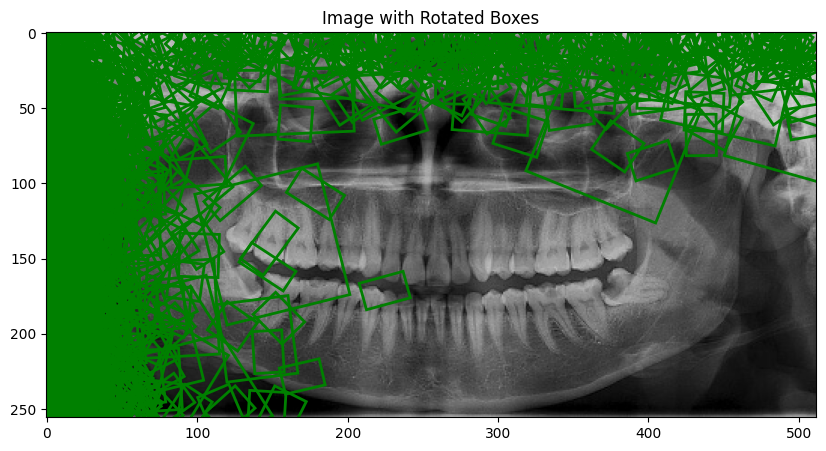

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image


def rotate_box(box):
    """Calculate the four corners of a rotated box (TensorFlow)."""
    x_min, y_min, x_max, y_max, angle = box
    cx = (x_min * 512 + x_max * 512)   / 2 
    cy = (y_min * 256 + y_max * 256)  / 2 
    dx = (x_max * 512 - x_min * 512) / 2  
    dy = (y_max * 256 - y_min * 256) / 2  
    angle = radians(angle * 360)
    # angle = 0
    # Calculate the four corners of the rotated rectangle
    corners = [
        (cx - dx * cos(angle) + dy * sin(angle), cy - dx * sin(angle) - dy * cos(angle)),
        (cx + dx * cos(angle) + dy * sin(angle), cy + dx * sin(angle) - dy * cos(angle)),
        (cx + dx * cos(angle) - dy * sin(angle), cy + dx * sin(angle) + dy * cos(angle)),
        (cx - dx * cos(angle) - dy * sin(angle), cy - dx * sin(angle) + dy * cos(angle))
    ]
    return corners

# Load the image

image = resized_image_X.squeeze(0).permute(1, 2, 0).numpy()

print(image.shape)


corners_boxes = []



fig, ax = plt.subplots(figsize=(10, 5))  # Adjust width and height as needed
ax.imshow(image/255.0)

for row in sliced_output[500:,:]:
    score = row[1]
    if score > 0.6:
        continue
    h, w = img.shape[:2]
    bbox = row[2:7] 
    corners = rotate_box(bbox)
    corners_boxes.append(corners)  




# Draw each box as a polygon
for corners in corners_boxes:
    polygon = patches.Polygon(corners, closed=True, edgecolor='green', linewidth=2, facecolor='none')
    ax.add_patch(polygon)


plt.title("Image with Rotated Boxes")
plt.axis("on")
plt.show()